##### Data Dictionary:

### RATINGS FILE DESCRIPTION
=========================================================================
All ratings are contained in the file **"ratings.dat"** and are in the following format:
`UserID::MovieID::Rating::Timestamp`

- **UserIDs** range between **1 and 6040**
- **MovieIDs** range between **1 and 3952**
- **Ratings** are made on a **5-star scale** (whole-star ratings only)
- **Timestamp** is represented in **seconds**
- **Each user has at least 20 ratings**

---

### USERS FILE DESCRIPTION
=========================================================================
User information is in the file **"users.dat"** and is in the following format:
`UserID::Gender::Age::Occupation::Zip-code`

- All demographic information is provided voluntarily by the users and is **not checked for accuracy**.
- Only users who have provided some demographic information are included in this dataset.
- **Gender** is denoted by:
  - `"M"` for male
  - `"F"` for female

#### Age Groups:
- `1`: "Under 18"
- `18`: "18-24"
- `25`: "25-34"
- `35`: "35-44"
- `45`: "45-49"
- `50`: "50-55"
- `56`: "56+"

#### Occupations:
- `0`: "Other" or not specified
- `1`: "Academic/Educator"
- `2`: "Artist"
- `3`: "Clerical/Admin"
- `4`: "College/Grad Student"
- `5`: "Customer Service"
- `6`: "Doctor/Health Care"
- `7`: "Executive/Managerial"
- `8`: "Farmer"
- `9`: "Homemaker"
- `10`: "K-12 Student"
- `11`: "Lawyer"
- `12`: "Programmer"
- `13`: "Retired"
- `14`: "Sales/Marketing"
- `15`: "Scientist"
- `16`: "Self-Employed"
- `17`: "Technician/Engineer"
- `18`: "Tradesman/Craftsman"
- `19`: "Unemployed"
- `20`: "Writer"

---

### MOVIES FILE DESCRIPTION
=========================================================================
Movie information is in the file **"movies.dat"** and is in the following format:
`MovieID::Title::Genres`

- Titles are identical to those provided by IMDB (including year of release).
- Genres are **pipe (`|`) separated** and are selected from the following genres:

  - **Action**
  - **Adventure**
  - **Animation**
  - **Children's**
  - **Comedy**
  - **Crime**
  - **Documentary**
  - **Drama**
  - **Fantasy**
  - **Film-Noir**
  - **Horror**
  - **Musical**
  - **Mystery**
  - **Romance**
  - **Sci-Fi**
  - **Thriller**
  - **War**
  - **Western**


In [425]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import mean_squared_error
from keras.src.losses import mean_squared_error
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Embedding, Flatten
from keras.layers import dot
from pylab import rcParams
from cmfrec import CMF
from seaborn import color_palette

warnings.filterwarnings('ignore')

In [273]:
users = pd.read_fwf('/Users/farazahmed/Downloads/drive-download-20250215T114129Z-001/zee-users.dat', encoding="ISO-8859-1")
ratings = pd.read_fwf('/Users/farazahmed/Downloads/drive-download-20250215T114129Z-001/zee-ratings.dat', encoding="ISO-8859-1")
movies = pd.read_fwf('/Users/farazahmed/Downloads/drive-download-20250215T114129Z-001/zee-movies.dat', encoding="ISO-8859-1")

In [274]:
users.head()

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


In [275]:
ratings.head()

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [276]:
movies.head()

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [277]:
# Splitting the rows in each table seperated by '::'
delimit = '::'
users = users['UserID::Gender::Age::Occupation::Zip-code'].str.split(delimit, expand=True)
users.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [278]:
ratings = ratings['UserID::MovieID::Rating::Timestamp'].str.split(delimit, expand=True)
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [279]:
movies = movies['Movie ID::Title::Genres'].str.split(delimit, expand=True)
movies.columns = ['Movie ID', 'Title', 'Genres']
movies.head()

,Movie ID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [280]:
# We notice that there are only 7 unique Age values, which represent a range.
users['Age'].value_counts()

Age
25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: count, dtype: int64

In [281]:
# Binning the age column.
users.replace({'Age':{'1':  "Under 18",
                      '18':  "18-24",
                      '25':  "25-34",
                      '35':  "35-44",
                      '45':  "45-49",
                      '50':  "50-55",
                      '56':  "56 Above"}}, inplace=True)

In [282]:
# Replacing the occupation values with their corresponding occupation names.
users.replace({'Occupation':{'0': "other",
                             '1': "academic/educator",
                             '2': "artist",
                             '3': "clerical/admin",
                             '4': "college/grad student",
                             '5': "customer service",
                             '6': "doctor/health care",
                             '7': "executive/managerial",
                             '8': "farmer",
                             '9': "homemaker",
                             '10': "k-12 student",
                             '11': "lawyer",
                             '12': "programmer",
                             '13': "retired",
                             '14': "sales/marketing",
                             '15': "scientist",
                             '16': "self-employed",
                             '17': "technician/engineer",
                             '18': "tradesman/craftsman",
                             '19': "unemployed",
                             '20': "writer"}}, inplace=True)

In [283]:
# Correcting 'MovieID' column name.
movies.columns = ['MovieID', 'Title', 'Genres']
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [284]:
# Merging movies and ratings.
df1 = pd.merge(movies, ratings, on='MovieID', how='inner')
df1.head()

,MovieID,Title,Genres,UserID,Rating,Timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474


In [285]:
# Merging with users.
df2 = pd.merge(df1, users, on='UserID', how='inner')
df2.head()

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,Under 18,k-12 student,48067
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008,F,50-55,homemaker,55117
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496,M,25-34,programmer,11413
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952,M,25-34,technician/engineer,61614
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474,F,35-44,academic/educator,95370


In [286]:
df_final = df2.copy(deep=True)

In [287]:
print("No. of rows: ", df_final.shape[0])
print("No. of columns: ", df_final.shape[1])

No. of rows:  1000209
No. of columns:  10


In [288]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   MovieID     1000209 non-null  object
 1   Title       1000209 non-null  object
 2   Genres      996144 non-null   object
 3   UserID      1000209 non-null  object
 4   Rating      1000209 non-null  object
 5   Timestamp   1000209 non-null  object
 6   Gender      1000209 non-null  object
 7   Age         1000209 non-null  object
 8   Occupation  1000209 non-null  object
 9   Zip-code    1000209 non-null  object
dtypes: object(10)
memory usage: 76.3+ MB


#### Feature Engineering

In [289]:
# Converting rating column to integer type.
df_final['Rating'] = df_final['Rating'].astype(int)

In [290]:
# We have the timestamp given to us in seconds, so converting it to datetime.
df_final['Timestamp'] = pd.to_datetime(df_final['Timestamp'], unit='s')

In [291]:
df_final.sample(50)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
304884,1199,Brazil (1985),Sci-Fi,5631,4,2000-05-24 02:29:51,M,35-44,programmer,01944
450178,1595,Free Willy 3: The Rescue (1997),Adventure|Children's|Drama,4572,2,2000-07-24 17:48:56,F,Under 18,k-12 student,17036
533277,1969,"Nightmare on Elm Street Part 2: Freddy's Revenge, A (1985)",Horro,2590,2,2000-11-10 07:21:14,M,18-24,college/grad student,94044
639909,2366,King Kong (1933),Action|Adventure|Horror,5046,5,2000-07-02 02:30:03,M,25-34,self-employed,60614
932169,3556,"Virgin Suicides, The (1999)",Comedy|Drama,4094,3,2001-01-21 20:36:32,M,25-34,technician/engineer,49017
32066,95,Broken Arrow (1996),Action|Thriller,5364,3,2000-06-09 20:33:57,F,25-34,clerical/admin,55408
825626,3081,Sleepy Hollow (1999),Horror|Romance,4132,4,2000-08-04 01:01:46,M,25-34,technician/engineer,80112
811231,3019,Drugstore Cowboy (1989),Crime|Drama,1749,4,2000-11-21 20:45:28,M,25-34,artist,10040
305973,1200,Aliens (1986),Action|Sci-Fi|Thriller|War,3563,5,2000-08-20 16:09:31,M,25-34,artist,33133
925870,3535,American Psycho (2000),Comedy|Horror|Thriller,1399,3,2000-11-20 23:48:18,M,18-24,technician/engineer,10804


In [292]:
# Extracting release year from the title and storing it in a new column.
df_final['Release Year'] = df_final['Title'].str.strip().str[-5:-1]
df_final.head()

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Release Year
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,2001-01-06 23:37:48,F,Under 18,k-12 student,48067,1995
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,2000-12-31 04:30:08,F,50-55,homemaker,55117,1995
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,2000-12-31 03:31:36,M,25-34,programmer,11413,1995
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,2000-12-31 01:25:52,M,25-34,technician/engineer,61614,1995
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,2000-12-31 01:34:34,F,35-44,academic/educator,95370,1995


In [293]:
# We notice some incorrect year values.
df_final['Release Year'].unique()

array(['1995', '1994', '1996', 'n th', '1976', '1993', '1992', '1988',
       '1967', '964)', '1977', 'der ', '1965', '(199', '1982', '1962',
       '1990', '1991', '1989', '1937', '1940', '1969', '1981', '1973',
       '1970', '1960', '1955', '1956', '1959', '1968', '1980', '1975',
       '995)', '1948', '1943', 'he B', '1950', '1987', '1997', ' Art',
       '1974', '1958', '1972', '1998', '1952', '1951', '1957', '1961',
       '1954', '1934', '1944', '1963', '1942', '1941', '1964', '1953',
       '1939', '1947', '1946', '1945', '1938', '1935', '1936', '1926',
       '1949', '1932', '1930', '1971', '1979', '1986', '1966', '1978',
       '1985', '1983', '1984', '1933', '1931', '1922', ') (1', '1927',
       '1929', ' (19', '1928', '1999', "e d'", 'olar', '(196', '1925',
       '981)', '1919', '(198', 'nd) ', '1923', '2000', 'n) (', '1920',
       '1921', 'dron', 'e (1', '989)'], dtype=object)

In [294]:
# Replacing incorrect year values where possible.
df_final['Release Year'].replace({'964)': '1964', '995)': '1995', '981)': '1981', '989)': '1989'}, inplace=True)
df_final['Release Year'].unique()

array(['1995', '1994', '1996', 'n th', '1976', '1993', '1992', '1988',
       '1967', '1964', '1977', 'der ', '1965', '(199', '1982', '1962',
       '1990', '1991', '1989', '1937', '1940', '1969', '1981', '1973',
       '1970', '1960', '1955', '1956', '1959', '1968', '1980', '1975',
       '1948', '1943', 'he B', '1950', '1987', '1997', ' Art', '1974',
       '1958', '1972', '1998', '1952', '1951', '1957', '1961', '1954',
       '1934', '1944', '1963', '1942', '1941', '1953', '1939', '1947',
       '1946', '1945', '1938', '1935', '1936', '1926', '1949', '1932',
       '1930', '1971', '1979', '1986', '1966', '1978', '1985', '1983',
       '1984', '1933', '1931', '1922', ') (1', '1927', '1929', ' (19',
       '1928', '1999', "e d'", 'olar', '(196', '1925', '1919', '(198',
       'nd) ', '1923', '2000', 'n) (', '1920', '1921', 'dron', 'e (1'],
      dtype=object)

In [295]:
# Dropping rows where the years do not make sense.

idx_val = df_final[(df_final['Release Year']=='n th') |
               (df_final['Release Year']=='der ') |
               (df_final['Release Year']=='(199') |
               (df_final['Release Year']=='he B') |
               (df_final['Release Year']==' Art') |
               (df_final['Release Year']==') (1') |
               (df_final['Release Year']==' (19') |
               (df_final['Release Year']=='Polar') |
               (df_final['Release Year']=="e d'") |
               (df_final['Release Year']=='olar') |
               (df_final['Release Year']=='(196') |
                (df_final['Release Year']=='(198') |
                (df_final['Release Year']=='nd) ') |
                (df_final['Release Year']=='n) (') |
                (df_final['Release Year']=='dron') |
                (df_final['Release Year']=='e (1')].index

df_final.drop(index=idx_val, inplace=True)
df_final['Release Year'].unique()

array(['1995', '1994', '1996', '1976', '1993', '1992', '1988', '1967',
       '1964', '1977', '1965', '1982', '1962', '1990', '1991', '1989',
       '1937', '1940', '1969', '1981', '1973', '1970', '1960', '1955',
       '1956', '1959', '1968', '1980', '1975', '1948', '1943', '1950',
       '1987', '1997', '1974', '1958', '1972', '1998', '1952', '1951',
       '1957', '1961', '1954', '1934', '1944', '1963', '1942', '1941',
       '1953', '1939', '1947', '1946', '1945', '1938', '1935', '1936',
       '1926', '1949', '1932', '1930', '1971', '1979', '1986', '1966',
       '1978', '1985', '1983', '1984', '1933', '1931', '1922', '1927',
       '1929', '1928', '1999', '1925', '1919', '1923', '2000', '1920',
       '1921'], dtype=object)

In [296]:
# Converting 'Release Year' to int data type.
df_final['Release Year'] = df_final['Release Year'].astype(int)

In [297]:
df_final.sample(5)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Release Year
99335,357,Four Weddings and a Funeral (1994),Comedy|Romance,770,5,2000-12-07 09:39:06,M,18-24,college/grad student,98499,1994
105515,372,Reality Bites (1994),Comedy|Drama,2024,2,2000-11-19 22:42:15,M,Under 18,unemployed,06614,1994
230046,924,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller,4666,4,2000-07-28 18:46:23,M,35-44,academic/educator,53704,1968
122309,454,"Firm, The (1993)",Drama|Thriller,5785,5,2000-05-19 14:41:49,F,25-34,executive/managerial,60607,1993
939184,3610,Roustabout (1964),Musical,4161,2,2000-08-03 21:29:44,M,45-49,other,90404,1964


In [298]:
# Creating the title column with only the title names.
df_final['Title'] = df_final['Title'].str.strip().str[:-7]
df_final.sample(5)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Release Year
218495,910,Some Like It Hot,Comedy|Crime,333,5,2001-07-28 21:32:55,M,35-44,artist,55410,1959
909497,3471,Close Encounters of the Third Kind,Drama|Sci-Fi,5433,3,2000-06-03 15:55:32,F,35-44,technician/engineer,45014,1977
304900,1199,Brazil,Sci-Fi,5722,4,2000-05-16 18:30:44,M,25-34,writer,48103,1985
866606,3256,Patriot Games,Action|Thriller,385,5,2000-12-08 18:42:04,M,25-34,doctor/health care,68131,1992
986320,3841,Air America,Action|Comedy,3901,4,2000-08-08 21:49:58,M,18-24,sales/marketing,85282,1990


In [299]:
# Creating a new column indicating the decade the movie was released.
bins = [1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 2000]
labels = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']
df_final['ReleaseDec'] = pd.cut(df_final['Release Year'], bins=bins, labels=labels)
df_final.sample(5)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Release Year,ReleaseDec
174787,610,Heavy Metal,Action|Adventure|Animation|Horror|Sci-Fi,2116,3,2001-01-22 23:57:06,M,18-24,college/grad student,49546,1981,80s
166898,593,"Silence of the Lambs, The",Drama|Thriller,3643,5,2000-08-18 21:42:32,M,25-34,technician/engineer,22302,1991,90s
141973,527,Schindler's List,Drama|War,845,4,2000-11-27 20:06:32,F,18-24,other,20009,1993,90s
989471,3868,"Naked Gun: From the Files of Police Squad!, The",Comedy,3703,5,2000-08-14 20:37:00,M,18-24,programmer,97402,1988,80s
985053,3833,"Brain That Wouldn't Die, The",Horror|Sci-Fi,3476,1,2000-09-14 16:40:33,M,50-55,other,44126,1962,60s


#### Data Cleaning

In [300]:
# Checking nulls
df_final.isna().sum()

MovieID           0
Title             0
Genres          521
UserID            0
Rating            0
Timestamp         0
Gender            0
Age               0
Occupation        0
Zip-code          0
Release Year      0
ReleaseDec       45
dtype: int64

In [301]:
df_final[df_final['Genres'].isna()]

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Release Year,ReleaseDec
55005,199,"Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les)",None,6,5,2000-12-31 04:39:30,F,50-55,homemaker,55117,1964,60s
55006,199,"Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les)",None,53,5,2000-12-28 04:59:11,M,25-34,other,96931,1964,60s
55007,199,"Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les)",None,59,3,2003-01-07 19:16:09,F,50-55,academic/educator,55413,1964,60s
55008,199,"Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les)",None,78,4,2000-12-26 06:24:55,F,45-49,academic/educator,98029,1964,60s
55009,199,"Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les)",None,155,4,2000-12-19 19:14:14,M,35-44,programmer,07470,1964,60s
...,...,...,...,...,...,...,...,...,...,...,...,...
954197,3695,"Toxic Avenger Part III: The Last Temptation of Toxie, The",None,4715,1,2000-07-13 22:35:22,M,25-34,artist,97205,1989,80s
954198,3695,"Toxic Avenger Part III: The Last Temptation of Toxie, The",None,4788,3,2000-07-07 19:13:45,M,35-44,executive/managerial,85331,1989,80s
954199,3695,"Toxic Avenger Part III: The Last Temptation of Toxie, The",None,4972,2,2000-07-03 06:43:32,M,35-44,other,95118,1989,80s
954200,3695,"Toxic Avenger Part III: The Last Temptation of Toxie, The",None,4979,2,2000-07-03 07:12:12,M,35-44,artist,55423,1989,80s


#### Exploratory Data Analysis and Visualization

In [302]:
df_final.sample(5)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Release Year,ReleaseDec
736051,2720,Inspector Gadget,Action|Adventure|Children's|Comedy,16,1,2000-12-30 11:09:57,F,35-44,other,20670,1999,90s
244661,1013,"Parent Trap, The",Children's|Drama,3957,4,2000-08-07 18:43:55,M,35-44,lawyer,40242,1961,60s
371155,1287,Ben-Hur,Action|Adventure|Drama,4683,3,2000-07-15 15:54:38,M,25-34,other,22101,1959,50s
201911,805,"Time to Kill, A",Drama,3336,3,2000-09-03 06:46:26,M,35-44,technician/engineer,93436,1996,90s
333381,1233,"Boat, The (Das Boot)",Action|Drama|War,3135,5,2000-09-16 01:16:37,M,25-34,scientist,12345,1981,80s


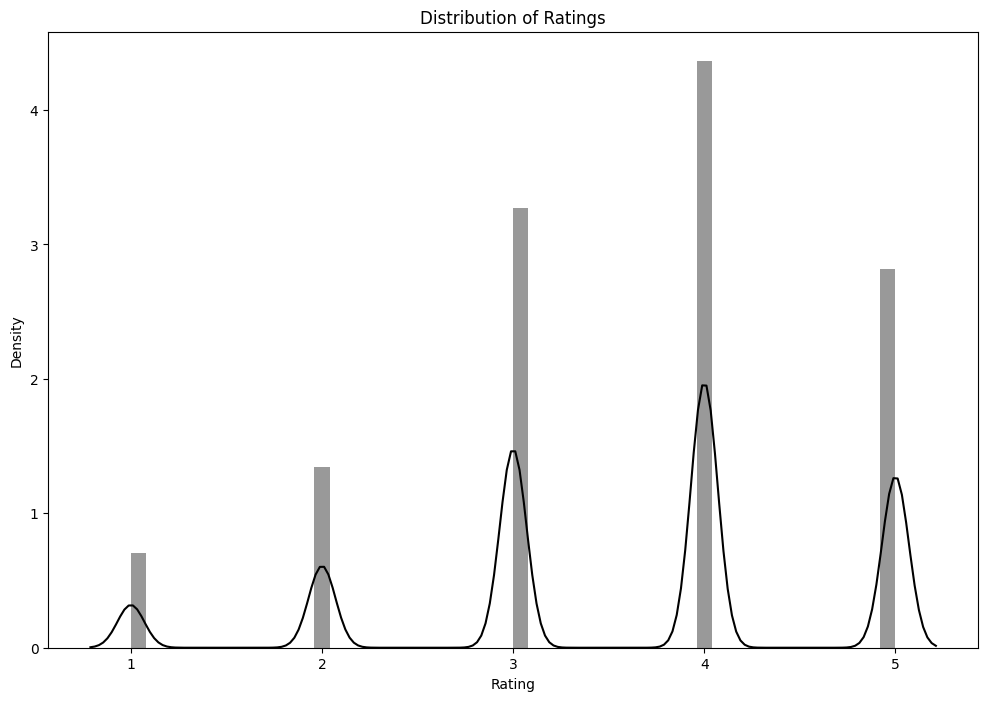

In [303]:
# Distribution of Ratings
plt.figure(figsize=(12, 8))
sns.distplot(df_final['Rating'], color='black', label='Rating')
plt.title('Distribution of Ratings')
plt.show()

##### From the above distribution we can observe that most of the movies are given rating 4.0

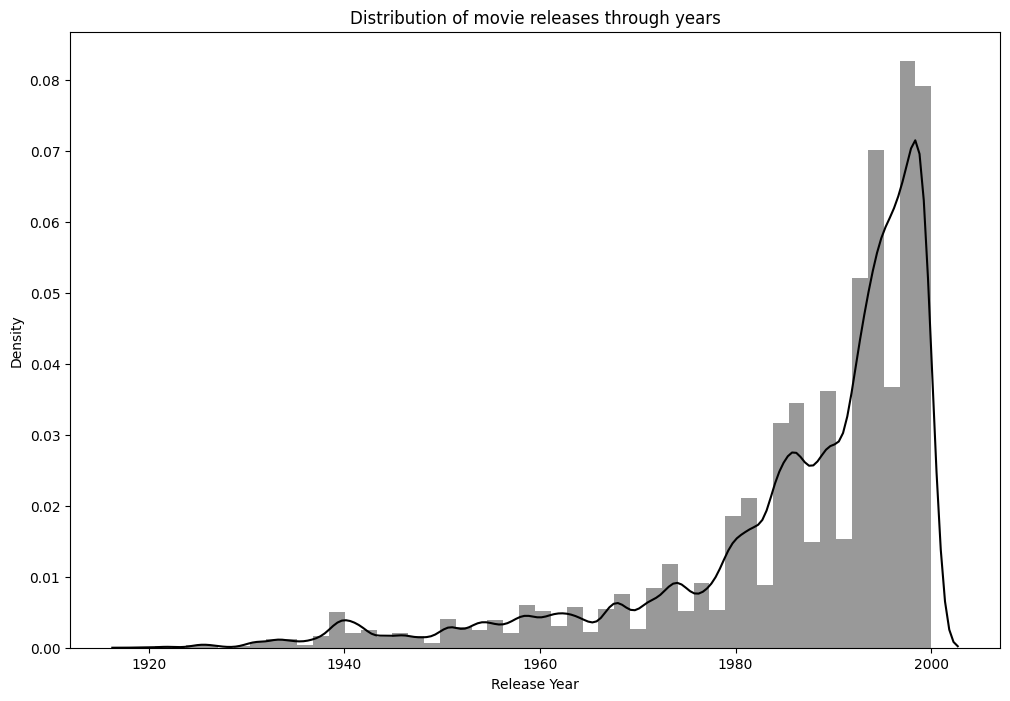

<Figure size 1200x800 with 0 Axes>

In [304]:
# Distribution of movies released through the years.
plt.figure(figsize=(12, 8))
sns.distplot(df_final['Release Year'], color='black', label='Release Year')
plt.title('Distribution of movie releases through years')
plt.figure(figsize=(12, 8))
plt.show()

##### As expected movie releases increase over the years, as validated by the above left skewed distribution.

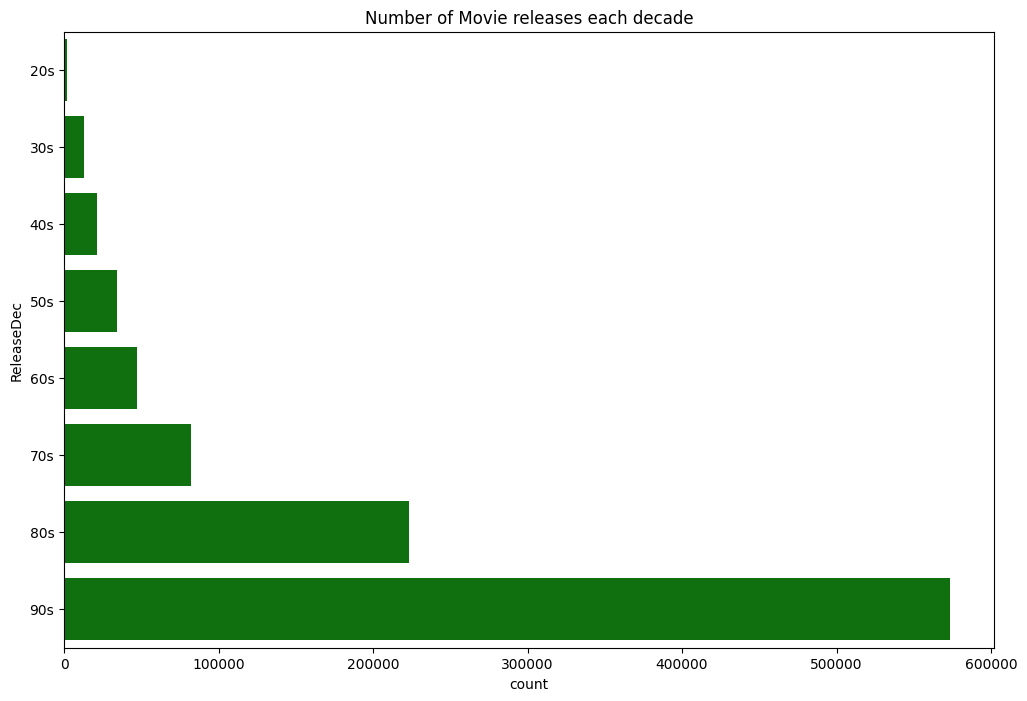

In [305]:
plt.figure(figsize=(12, 8))
sns.countplot(df_final['ReleaseDec'], color='green')
plt.title('Number of Movie releases each decade')
plt.show()

##### From our data, most of the movies are released in the 90s

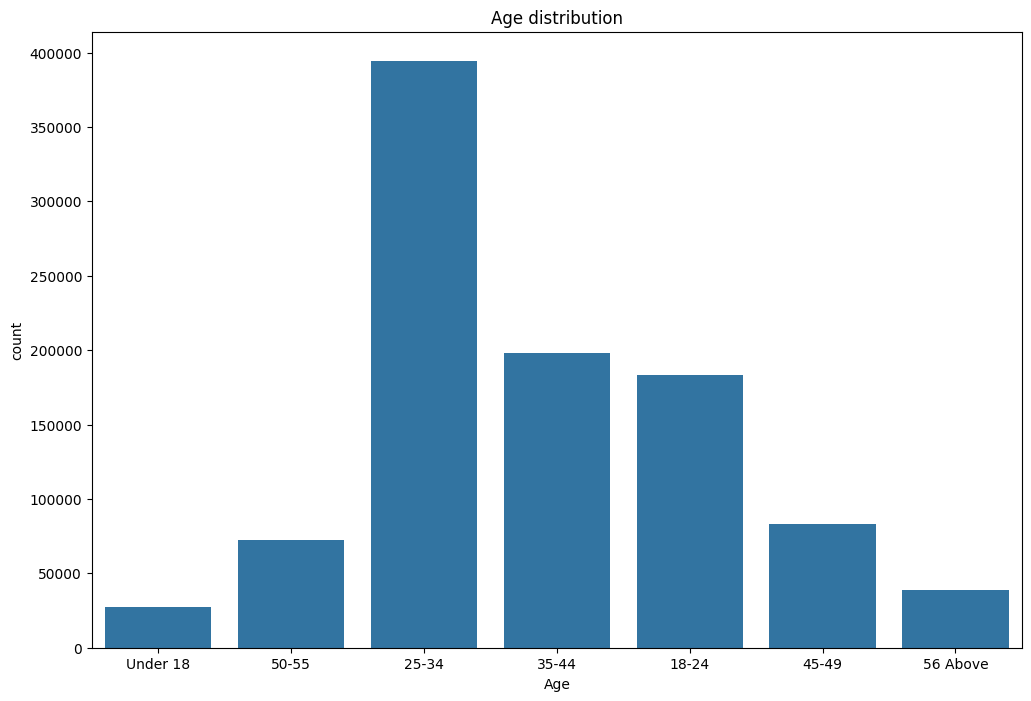

In [306]:
plt.figure(figsize=(12, 8))
sns.countplot(x=df_final['Age'])
plt.title('Age distribution')
plt.show()

##### Media consumption is maximum for ages between 25 to 34, hence the business can focus on creating more tailored content for this age range.

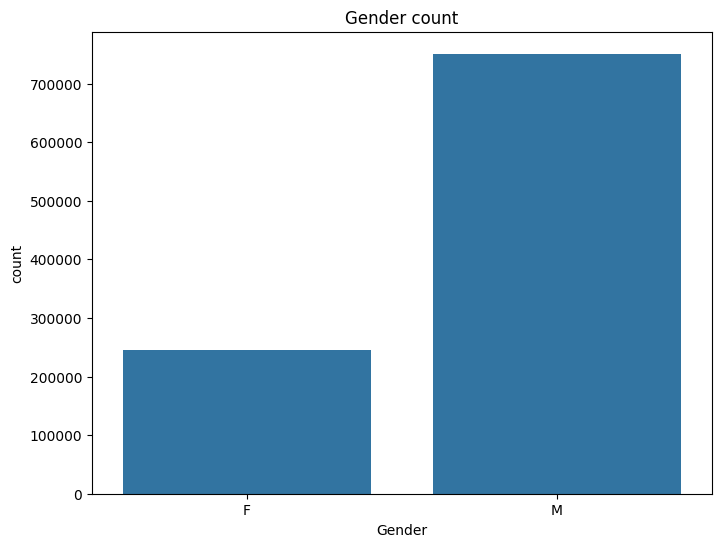

In [307]:
plt.figure(figsize=(8, 6))
sns.countplot(x=df_final['Gender'])
plt.title('Gender count')
plt.show()

##### Males consume more content than females

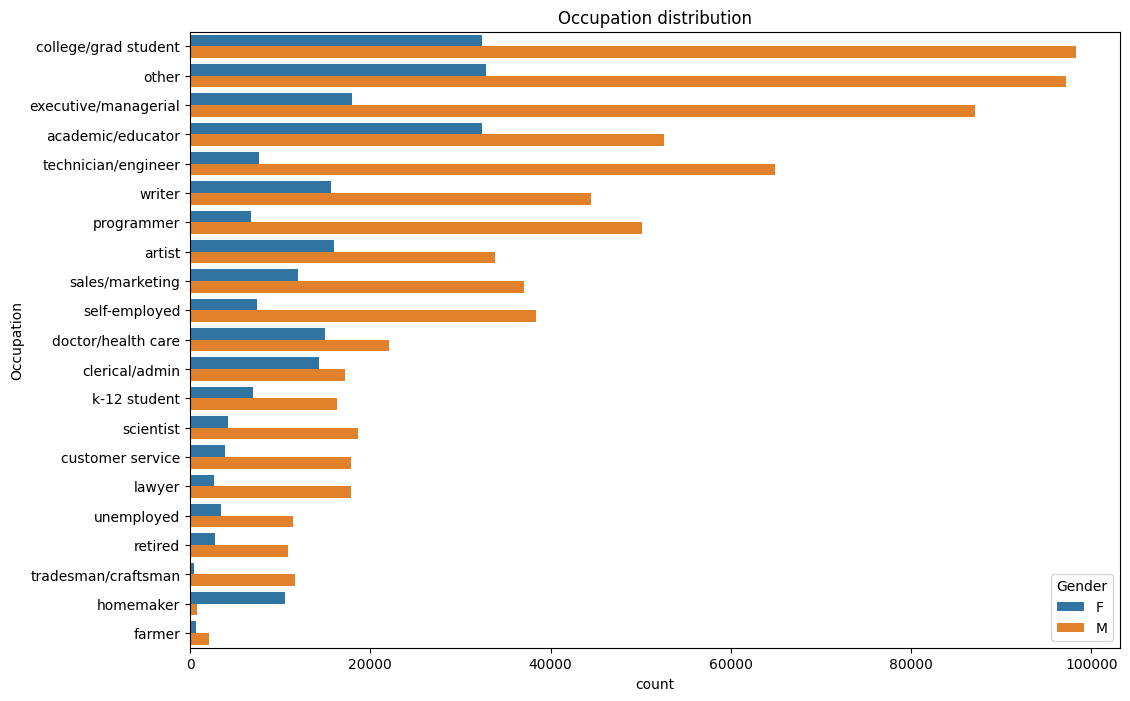

In [308]:
# Distribution of Occupation.
sorted_counts = df_final['Occupation'].value_counts()
plt.figure(figsize=(12, 8))
sns.countplot(data=df_final, y=df_final['Occupation'], order=sorted_counts.index, hue='Gender')
plt.title('Occupation distribution')
plt.show()

##### College going students are the major consumers of media, which aligns with our age distribution as well.

In [309]:
df_final

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Release Year,ReleaseDec
0,1,Toy Story,Animation|Children's|Comedy,1,5,2001-01-06 23:37:48,F,Under 18,k-12 student,48067,1995,90s
1,1,Toy Story,Animation|Children's|Comedy,6,4,2000-12-31 04:30:08,F,50-55,homemaker,55117,1995,90s
2,1,Toy Story,Animation|Children's|Comedy,8,4,2000-12-31 03:31:36,M,25-34,programmer,11413,1995,90s
3,1,Toy Story,Animation|Children's|Comedy,9,5,2000-12-31 01:25:52,M,25-34,technician/engineer,61614,1995,90s
4,1,Toy Story,Animation|Children's|Comedy,10,5,2000-12-31 01:34:34,F,35-44,academic/educator,95370,1995,90s
...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,3952,"Contender, The",Drama|Thriller,5812,4,2001-06-09 07:34:59,F,25-34,executive/managerial,92120,2000,90s
1000205,3952,"Contender, The",Drama|Thriller,5831,3,2001-04-02 14:52:05,M,25-34,academic/educator,92120,2000,90s
1000206,3952,"Contender, The",Drama|Thriller,5837,4,2002-01-24 20:04:16,M,25-34,executive/managerial,60607,2000,90s
1000207,3952,"Contender, The",Drama|Thriller,5927,1,2001-01-18 21:15:37,M,35-44,sales/marketing,10003,2000,90s


In [310]:
# Top 3 Genre by age groups.
df_temp = df_final.groupby(['Age', 'Genres'])['Rating'].mean().reset_index().sort_values(by=['Age', 'Rating'], ascending=[True, False]).groupby('Age').head(3)
df_temp

,Age,Genres,Rating
185,18-24,Animation|Comedy|Thriller,4.562500
4,18-24,Action|Adv,4.442142
31,18-24,Action|Adventure|Fantas,4.427046
356,25-34,Acti,5.000000
385,25-34,Action|Adventure|Fantas,4.572695
539,25-34,Animation|Comedy|Thriller,4.506711
841,35-44,Adventure|Children's|Drama|Musical,4.446384
892,35-44,Animation|Comedy|Thriller,4.364238
739,35-44,Action|Adventure|Fantas,4.354633
1337,45-49,Document,5.000000


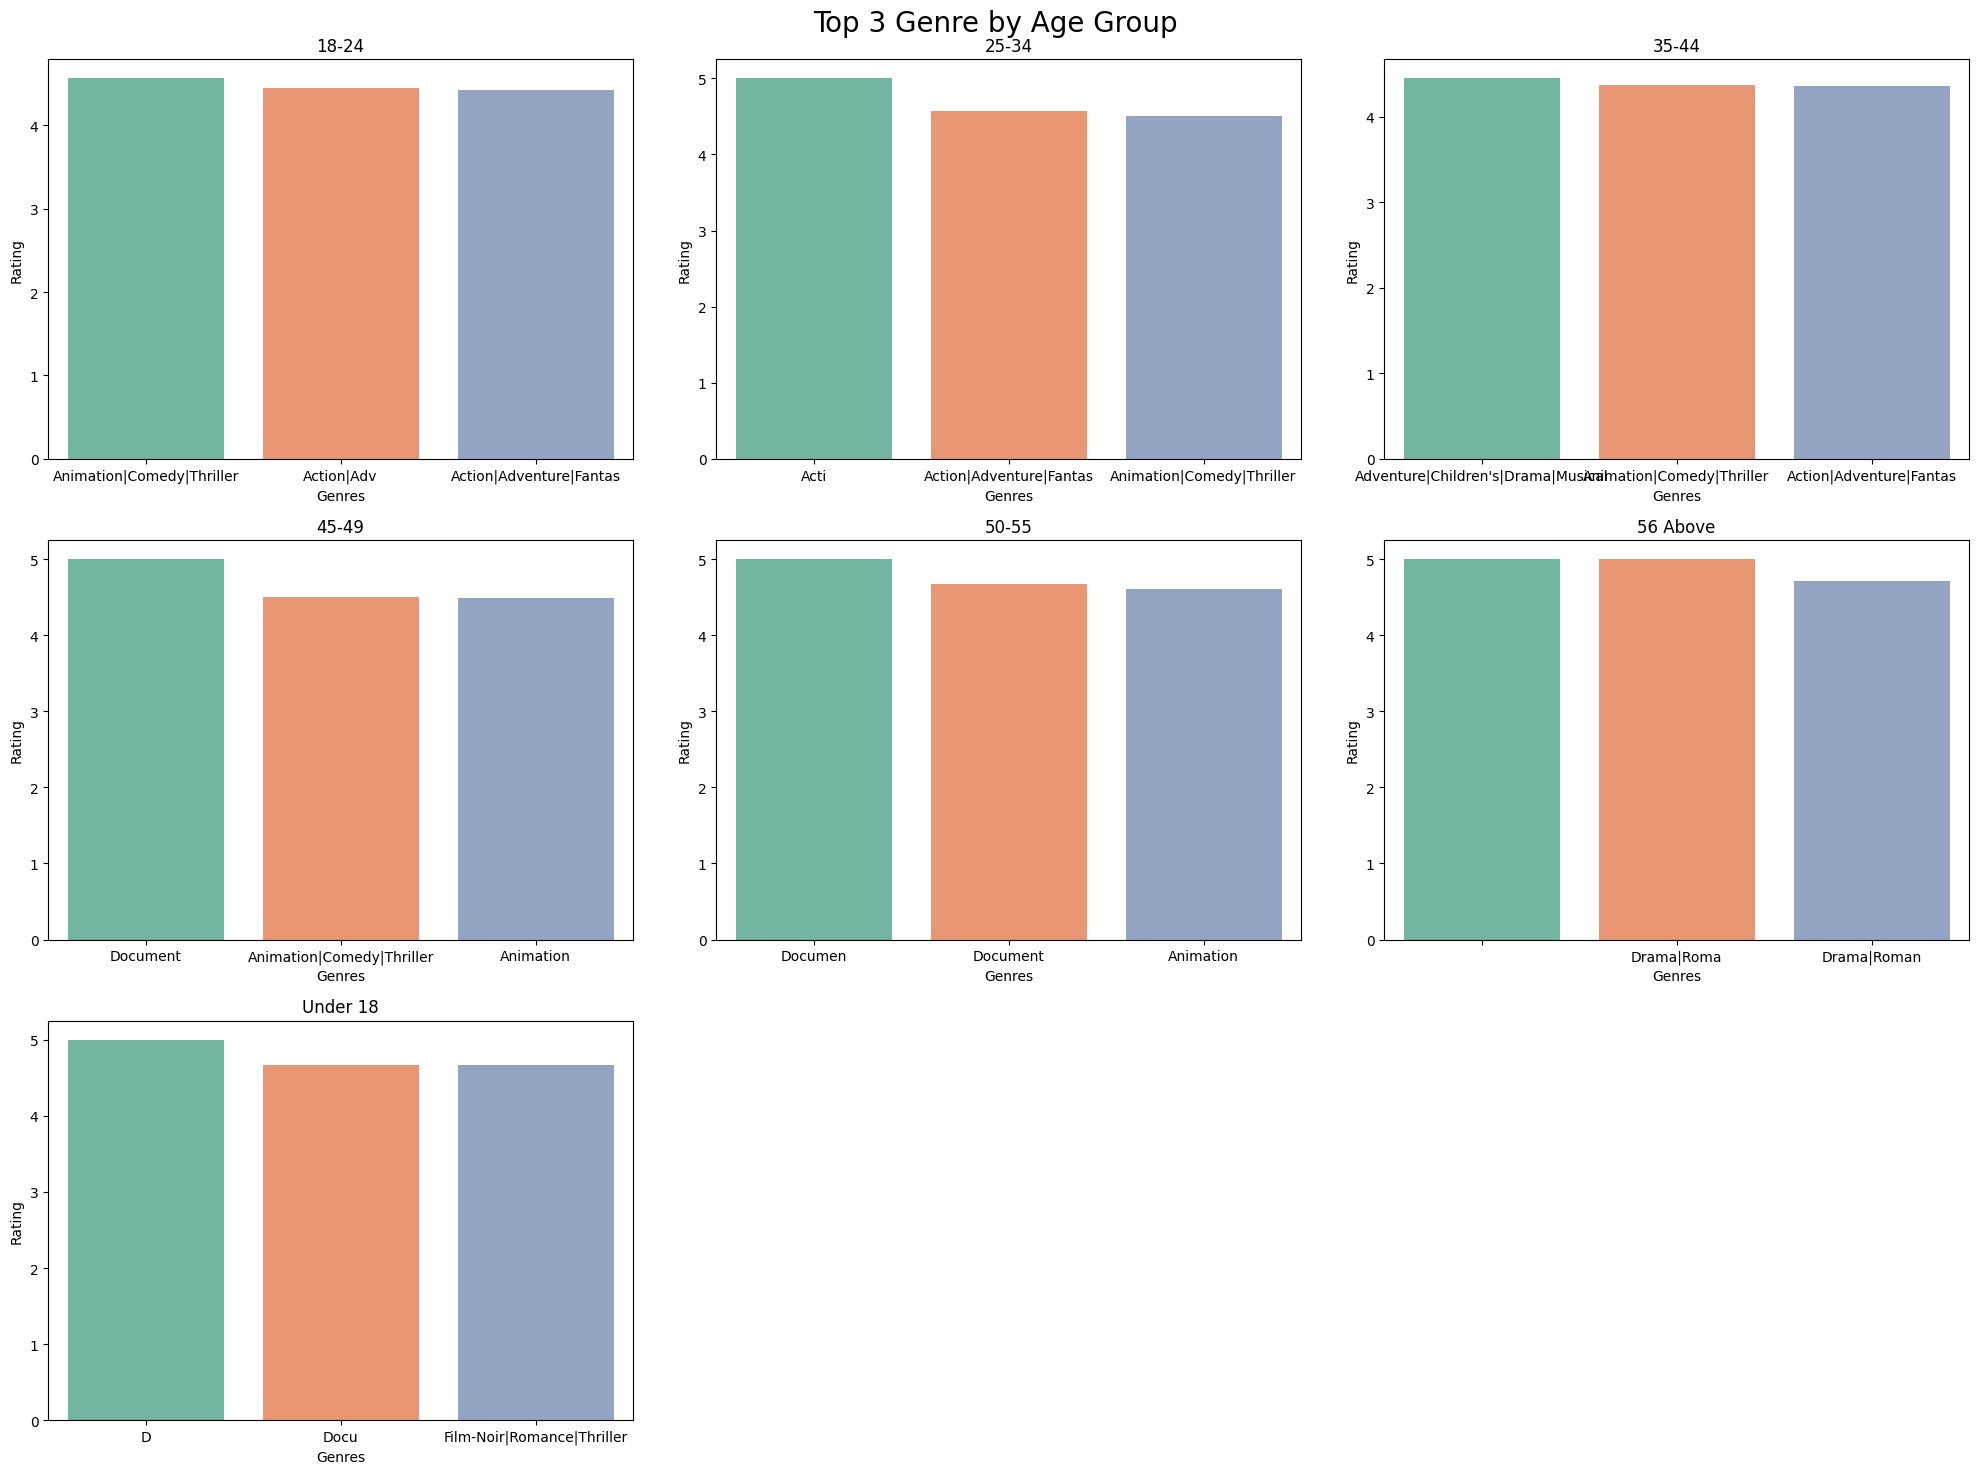

In [311]:
# Plots for top 3 genre by age groups.
fig, ax = plt.subplots(figsize=(20, 15), nrows=3, ncols=3)
fig.suptitle('Top 3 Genre by Age Group', fontsize=20)

palette = sns.color_palette("Set2")  # Feel free to change to other palettes like "Paired", "tab10", etc.

# Age 18-24
df_age1 = df_temp[df_temp['Age'] == '18-24']
sns.barplot(data=df_age1, x=df_age1['Genres'], y=df_age1['Rating'], ax=ax[0, 0], palette=palette)
ax[0, 0].set_title('18-24')

# Age 25-34
df_age2 = df_temp[df_temp['Age'] == '25-34']
sns.barplot(data=df_age2, x=df_age2['Genres'], y=df_age2['Rating'], ax=ax[0, 1], palette=palette)
ax[0, 1].set_title('25-34')

# Age 35-44
df_age3 = df_temp[df_temp['Age'] == '35-44']
sns.barplot(data=df_age3, x=df_age3['Genres'], y=df_age3['Rating'], ax=ax[0, 2], palette=palette)
ax[0, 2].set_title('35-44')

# Age 45-49
df_age4 = df_temp[df_temp['Age'] == '45-49']
sns.barplot(data=df_age4, x=df_age4['Genres'], y=df_age4['Rating'], ax=ax[1, 0], palette=palette)
ax[1, 0].set_title('45-49')

# Age 50-55
df_age5 = df_temp[df_temp['Age'] == '50-55']
sns.barplot(data=df_age5, x=df_age5['Genres'], y=df_age5['Rating'], ax=ax[1, 1], palette=palette)
ax[1, 1].set_title('50-55')

# Age 56 Above
df_age6 = df_temp[df_temp['Age'] == '56 Above']
sns.barplot(data=df_age6, x=df_age6['Genres'], y=df_age6['Rating'], ax=ax[1, 2], palette=palette)
ax[1, 2].set_title('56 Above')

# Under 18
df_age7 = df_temp[df_temp['Age'] == 'Under 18']
sns.barplot(data=df_age7, x=df_age7['Genres'], y=df_age7['Rating'], ax=ax[2, 0], palette=palette)
ax[2, 0].set_title('Under 18')

fig.tight_layout()
fig.delaxes(ax[2, 1])
fig.delaxes(ax[2, 2])

plt.show()

In [312]:
# Top 10 titles by average rating.
df_final.groupby('Title')['Rating'].mean().reset_index().sort_values(by=['Rating'], ascending=False).head(10)

,Title,Rating
1993,Lured,5.0
2994,Smashing Time,5.0
1282,"Gate of Heavenly Peace, The",5.0
2411,One Little Indian,5.0
1189,Follow the Bitch,5.0
404,Bittersweet Motel,5.0
3421,Ulysses (Ulisse),5.0
2855,Schlafes Bruder (Brother of Sleep),5.0
247,"Baby, The",5.0
3037,Song of Freedom,5.0


In [313]:
# Top 10 most rated titles
df_final.groupby('Title')['Rating'].count().reset_index().sort_values(by=['Rating'], ascending=False).head(10)

,Title,Rating
125,American Beauty,3428
3103,Star Wars: Episode IV - A New Hope,2991
3104,Star Wars: Episode V - The Empire Strikes Back,2990
3105,Star Wars: Episode VI - Return of the Jedi,2883
1764,Jurassic Park,2672
2847,Saving Private Ryan,2653
3242,Terminator 2: Judgment Day,2649
2078,"Matrix, The",2590
256,Back to the Future,2583
2940,"Silence of the Lambs, The",2578


#### Model Building
##### The model will be built using collaborative filtering and we will explore both user-user and item-item based approaches.

In [314]:
# Taking the mean of rating in case the user gave more than one rating to same title.
df_matrix = df_final.groupby(['UserID', 'Title'])['Rating'].mean().reset_index()

In [315]:
# Creating interaction table for user, title and rating using pivot table.
interaction_matrix = pd.pivot_table(df_matrix, values='Rating', index='UserID', columns='Title')
interaction_matrix

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [316]:
# Replacing NaN with zeros.
interaction_matrix.fillna(0, inplace=True)

In [317]:
interaction_matrix

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Recommendation with Pearson correlation

###### Item based approach

In [468]:
# Input a movie title.
movie = input('Enter movie title: ')
print(f"Movie title: {movie}")

Movie title: Terminator, The


In [469]:
# Getting the top 5 movies with the highest correlation.
movie_rating_vector = interaction_matrix[movie]
similar_movies = interaction_matrix.corrwith(movie_rating_vector)
similar_movies_df = pd.DataFrame(similar_movies, columns=['Correlation'])
similar_movies_df.sort_values(by=['Correlation'], ascending=False, inplace=True)
similar_movies_df.iloc[1:6]

,Correlation
Title,
Aliens,0.625018
Predator,0.577138
Die Hard,0.575858
Alien,0.563853
Terminator 2: Judgment Day,0.562806


##### We can see above that for a given movie title 'Terminator', which is an Action/Sci-Fi genre, we get movies within similar genre. You can try for other titles!

##### Recommendation with Cosine Similarity
###### Cosine similarity gives an estimate if two vectors are point roughly in the same direction. The values varies between -1 and 1.
###### In our case, we will measure the similarity between the movie input by the user with all the movies in the data.

In [320]:
# Item-Item based similarity
item_sim = cosine_similarity(interaction_matrix.transpose())
item_sim

array([[1.        , 0.07235746, 0.03701053, ..., 0.        , 0.12024178,
        0.02700277],
       [0.07235746, 1.        , 0.11528952, ..., 0.        , 0.        ,
        0.07780705],
       [0.03701053, 0.11528952, 1.        , ..., 0.        , 0.04752635,
        0.0632837 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.04564448],
       [0.12024178, 0.        , 0.04752635, ..., 0.        , 1.        ,
        0.04433508],
       [0.02700277, 0.07780705, 0.0632837 , ..., 0.04564448, 0.04433508,
        1.        ]])

In [321]:
item_sim_matrix = pd.DataFrame(item_sim, columns=interaction_matrix.columns, index=interaction_matrix.columns)
item_sim_matrix

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",1.000000,0.072357,0.037011,0.079291,0.060838,0.000000,0.058619,0.189843,0.094785,0.058418,...,0.038725,0.076474,0.000000,0.044074,0.0,0.045280,0.039395,0.000000,0.120242,0.027003
'Night Mother,0.072357,1.000000,0.115290,0.115545,0.159526,0.000000,0.076798,0.137135,0.111413,0.046135,...,0.053010,0.087828,0.063758,0.135962,0.0,0.091150,0.074787,0.000000,0.000000,0.077807
'Til There Was You,0.037011,0.115290,1.000000,0.098756,0.066301,0.080250,0.127895,0.128523,0.079115,0.066598,...,0.029200,0.062893,0.000000,0.079187,0.0,0.022594,0.079261,0.000000,0.047526,0.063284
"'burbs, The",0.079291,0.115545,0.098756,1.000000,0.143620,0.000000,0.192191,0.250140,0.170719,0.197808,...,0.113386,0.207897,0.019962,0.138064,0.0,0.055704,0.161174,0.000000,0.033567,0.110525
...And Justice for All,0.060838,0.159526,0.066301,0.143620,1.000000,0.000000,0.075093,0.178928,0.205486,0.122431,...,0.089998,0.153006,0.067009,0.109029,0.0,0.086080,0.110867,0.074317,0.000000,0.111040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Zed & Two Noughts, A",0.045280,0.091150,0.022594,0.055704,0.086080,0.000000,0.012702,0.042295,0.039344,0.041324,...,0.047282,0.073996,0.070409,0.141537,0.0,1.000000,0.084020,0.124939,0.000000,0.137372
Zero Effect,0.039395,0.074787,0.079261,0.161174,0.110867,0.000000,0.175771,0.157313,0.133061,0.156505,...,0.179315,0.169677,0.021362,0.206870,0.0,0.084020,1.000000,0.059228,0.016838,0.242043
Zero Kelvin (Kjærlighetens kjøtere),0.000000,0.000000,0.000000,0.000000,0.074317,0.000000,0.000000,0.033120,0.036867,0.034797,...,0.048440,0.046892,0.000000,0.000000,0.0,0.124939,0.059228,1.000000,0.000000,0.045644


In [322]:
# Testing item-item recommendations
movie = input('Enter movie title: ')
print(f"Movie title: {movie}")

Movie title: Liar Liar


In [323]:
#We can see similar quality of recommendations for cosine similarity.
item_sim_matrix[movie].sort_values(ascending=False).iloc[1:6]

Title
Mrs. Doubtfire                0.557067
Ace Ventura: Pet Detective    0.516861
Dumb & Dumber                 0.512585
Home Alone                    0.511204
Wayne's World                 0.499368
Name: Liar Liar, dtype: float64

In [324]:
df_final['UserID'] = df_final['UserID'].astype(int)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 996665 entries, 0 to 1000208
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   MovieID       996665 non-null  object        
 1   Title         996665 non-null  object        
 2   Genres        996144 non-null  object        
 3   UserID        996665 non-null  int64         
 4   Rating        996665 non-null  int64         
 5   Timestamp     996665 non-null  datetime64[ns]
 6   Gender        996665 non-null  object        
 7   Age           996665 non-null  object        
 8   Occupation    996665 non-null  object        
 9   Zip-code      996665 non-null  object        
 10  Release Year  996665 non-null  int64         
 11  ReleaseDec    996620 non-null  category      
dtypes: category(1), datetime64[ns](1), int64(3), object(7)
memory usage: 92.2+ MB


##### User-user based approach

In [325]:
# User-user based recommendation.

user_sim = cosine_similarity(interaction_matrix)
user_sim

array([[1.        , 0.25531859, 0.12396703, ..., 0.15926709, 0.11935626,
        0.12239079],
       [0.25531859, 1.        , 0.25964457, ..., 0.16569953, 0.13332665,
        0.24845029],
       [0.12396703, 0.25964457, 1.        , ..., 0.20430203, 0.11352239,
        0.30693676],
       ...,
       [0.15926709, 0.16569953, 0.20430203, ..., 1.        , 0.18657496,
        0.18563871],
       [0.11935626, 0.13332665, 0.11352239, ..., 0.18657496, 1.        ,
        0.10827118],
       [0.12239079, 0.24845029, 0.30693676, ..., 0.18563871, 0.10827118,
        1.        ]])

In [326]:
user_sim_matrix = pd.DataFrame(user_sim, columns=interaction_matrix.index, index=interaction_matrix.index)
user_sim_matrix

UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.255319,0.123967,0.207800,0.139317,0.110320,0.121384,0.180226,0.103896,0.052816,...,0.079367,0.038048,0.032136,0.067631,0.070052,0.035731,0.170184,0.159267,0.119356,0.122391
10,0.255319,1.000000,0.259645,0.280479,0.158703,0.112917,0.141985,0.432536,0.194915,0.102487,...,0.154412,0.186234,0.083739,0.125894,0.118558,0.146552,0.304806,0.165700,0.133327,0.248450
100,0.123967,0.259645,1.000000,0.306067,0.075736,0.110450,0.358686,0.237492,0.172872,0.099147,...,0.098235,0.097953,0.065152,0.178664,0.271311,0.033754,0.344290,0.204302,0.113522,0.306937
1000,0.207800,0.280479,0.306067,1.000000,0.099117,0.047677,0.201722,0.355920,0.325966,0.130702,...,0.170100,0.076779,0.000000,0.200343,0.380741,0.044404,0.330748,0.172803,0.098456,0.250564
1001,0.139317,0.158703,0.075736,0.099117,1.000000,0.164854,0.053887,0.150196,0.138602,0.134710,...,0.146270,0.026891,0.097011,0.119609,0.092234,0.109700,0.222119,0.103255,0.269952,0.178399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.035731,0.146552,0.033754,0.044404,0.109700,0.072578,0.031406,0.088838,0.061450,0.032265,...,0.080559,0.252222,0.074207,0.098705,0.048650,1.000000,0.063925,0.019459,0.075830,0.052571
996,0.170184,0.304806,0.344290,0.330748,0.222119,0.224779,0.185226,0.352014,0.287965,0.164045,...,0.205186,0.086546,0.062523,0.186441,0.217672,0.063925,1.000000,0.179404,0.178834,0.418466
997,0.159267,0.165700,0.204302,0.172803,0.103255,0.068980,0.170771,0.175488,0.106303,0.049536,...,0.192642,0.030588,0.081380,0.162615,0.110656,0.019459,0.179404,1.000000,0.186575,0.185639


In [332]:
# Top 5 users similar to UserID 1
user_sim_matrix['1'].sort_values(ascending=False).iloc[1:6].reset_index()

,UserID,1
0,5343,0.412117
1,5190,0.411899
2,1481,0.392110
3,1283,0.386597
4,5705,0.360898


In [337]:
# Recommending UserID 1 with the top-rated movies of UserID 5343.
df_final[df_final['UserID'] == 5343].sort_values(by='Rating', ascending=False).head(5)['Title']

1822                       Toy Story
275585    E.T. the Extra-Terrestrial
894496               Erin Brockovich
876313                   Boiler Room
838098                   Toy Story 2
Name: Title, dtype: object

#### Recommendation using Nearest Neighbours

In [363]:
# Initializing and fitting the model.
knn = NearestNeighbors(n_neighbors=5, metric='cosine', n_jobs=-1)
knn.fit(interaction_matrix.transpose())

NearestNeighbors(metric='cosine', n_jobs=-1)

In [460]:
movie_name = input('Enter movie title: ')
print(f"Movie title: {movie_name}")

Movie title: E.T. the Extra-Terrestrial


In [461]:
movie_rating_vector = interaction_matrix[movie_name].values.reshape(1,-1)
distances, indices = knn.kneighbors(movie_rating_vector, n_neighbors=10)

In [462]:
indices

array([[ 997, 3104,  256, 3103,  707, 3105, 3243, 2666,  373,  100]])

In [463]:
distances

array([[3.33066907e-16, 3.41503600e-01, 3.55167911e-01, 3.55846274e-01,
        3.93512648e-01, 3.96135929e-01, 4.02684191e-01, 4.11986081e-01,
        4.14823636e-01, 4.30333688e-01]])

In [464]:
interaction_matrix

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [465]:
# Getting the top 10 recommendations for the given movie title.
for i in range(0, len(distances.flatten())):
    if i > 0:
        print(f"Movie title: {interaction_matrix.columns[indices.flatten()[i]]}, Distance: {round(distances.flatten()[i], 3)}")

Movie title: Star Wars: Episode V - The Empire Strikes Back, Distance: 0.342
Movie title: Back to the Future, Distance: 0.355
Movie title: Star Wars: Episode IV - A New Hope, Distance: 0.356
Movie title: Close Encounters of the Third Kind, Distance: 0.394
Movie title: Star Wars: Episode VI - Return of the Jedi, Distance: 0.396
Movie title: Terminator, The, Distance: 0.403
Movie title: Raiders of the Lost Ark, Distance: 0.412
Movie title: Big, Distance: 0.415
Movie title: Aliens, Distance: 0.43


##### We can compare our recommendations with Google recommendations.
##### For 'E.T. the Extra-Terrestrial' we can observe 5 matching recommendations.

<img src="GoogleImage.png" alt="Google Image" width="1000">

<img src="GoogleImage2.png" alt="Google Image" width="1000">

#### Matrix Factorization

In [379]:
# Converting our matrix into a format that is accepted in the 'Collective Matrix Factorization(CMF)' Model.
df_final1 = df_final.groupby(['UserID', 'MovieID'])['Rating'].mean().reset_index()
df_final1

,UserID,MovieID,Rating
0,1,1,5.0
1,1,1022,5.0
2,1,1028,5.0
3,1,1029,5.0
4,1,1035,5.0
...,...,...,...
996660,6040,924,5.0
996661,6040,930,4.0
996662,6040,953,5.0
996663,6040,978,4.0


In [380]:
# The column names need to be specified in the following format.
df_final1.columns = ['UserId', 'ItemId', 'Rating']
df_final1

,UserId,ItemId,Rating
0,1,1,5.0
1,1,1022,5.0
2,1,1028,5.0
3,1,1029,5.0
4,1,1035,5.0
...,...,...,...
996660,6040,924,5.0
996661,6040,930,4.0
996662,6040,953,5.0
996663,6040,978,4.0


In [393]:
# Initializing and fitting the CMF model.
# We observed best recommending performance at latent factor(k) = 50
model = CMF(k = 50, lambda_ = 0.1, method = 'als', verbose = False, user_bias= True, item_bias=True)
model.fit(df_final1)

Collective matrix factorization model
(explicit-feedback variant)


##### Checking the decomposed matrices

In [394]:
model.A_.shape

(6040, 50)

In [395]:
model.B_.shape

(3688, 50)

In [403]:
model.A_

array([[-0.1663111 , -0.35740718, -0.14375742, ...,  0.3910242 ,
         0.04500171, -0.33100483],
       [ 0.1016819 ,  0.30709732, -0.53123623, ...,  0.21531495,
        -0.06886604, -0.28106728],
       [-0.3999729 , -0.04531595, -0.02362243, ..., -0.20085117,
        -0.36876145, -0.38098893],
       ...,
       [ 0.21978293,  0.0194169 , -0.20384872, ...,  0.02268497,
        -0.12464507,  0.00528312],
       [-0.10699342, -0.07639977, -0.22588864, ..., -0.2819264 ,
         0.00425149, -0.24320532],
       [-0.10600317, -0.1003447 ,  0.2618368 , ...,  0.04189836,
         0.01327618,  0.35894626]], dtype=float32)

In [397]:
model.B_

array([[-0.7878004 ,  0.19797577,  0.01178181, ...,  0.0300901 ,
         0.5973363 , -0.23918428],
       [-0.3644704 ,  0.5676954 , -0.56440276, ...,  0.21383812,
         0.6757872 , -1.3009099 ],
       [-0.24597625, -0.5008006 , -1.8338157 , ...,  0.36752027,
         0.38806567, -0.66016644],
       ...,
       [-0.2233003 ,  0.10653394,  0.13444254, ..., -0.11533676,
        -0.01949675, -0.01913491],
       [-0.00338947, -0.05348425,  0.02881148, ...,  0.02657624,
         0.0184701 ,  0.00209118],
       [ 0.00822021, -0.0219715 , -0.0203547 , ...,  0.01762223,
         0.01202193, -0.00588354]], dtype=float32)

In [398]:
model.glob_mean_

3.5799641609191895

In [399]:
# Testing recommendations for users (here, user id = 5343)
top_items = model.topN(user = 5343, n = 10)
top_items

array(['3194', '2041', '2384', '957', '3742', '1395', '34', '3554',
       '3598', '3457'], dtype=object)

In [400]:
# Checking the recommended movies.
movies.loc[movies.MovieID.isin(top_items)]

,MovieID,Title,Genres
33,34,Babe (1995),Children's|Comedy|Drama
945,957,"Scarlet Letter, The (1926)",Drama
1374,1395,Tin Men (1987),Comedy|Drama
1972,2041,Condorman (1981),Action|Adventure|Children's|Comedy
2315,2384,Babe: Pig in the City (1998),Children's|Comedy
3125,3194,"Way We Were, The (1973)",Drama
3388,3457,Waking the Dead (1999),Drama
3485,3554,Love and Basketball (2000),Drama|Romance
3529,3598,Hamlet (2000),Drama
3673,3742,"Battleship Potemkin, The (Bronenosets Potyomkin) (1925)",Drama|Wa


In [401]:
# For comparison with our recommended movies, we get the list of top 10 highly rated movies by this user(5343).
df_final[df_final['UserID'] == 5343].sort_values(by='Rating', ascending=False)[['Title','Genres']].head(10)

,Title,Genres
1822,Toy Story,Animation|Children's|Comedy
275585,E.T. the Extra-Terrestrial,Children's|Drama|Fantasy|Sci-F
894496,Erin Brockovich,Drama
876313,Boiler Room,Drama
838098,Toy Story 2,Animation|Children's|Comedy
769658,American Beauty,Comedy|Drama
747671,"Sixth Sense, The",Thriller
569766,"Little Mermaid, The",Animation|Children's|Comedy|Musical|R
568765,Lady and the Tramp,Animation|Children's|Comedy|Musical|Ro
567896,"Jungle Book, The",Animation|Children's|Comedy|Musical


##### We can observe that the recommended genres of the movies is very close to what this user likes.

*-----------------------------------------------------------------------------------------------------------------------------------------------------------------*